In [ ]:
pip install dask geopandas xarray rasterio numba matplotlib dask-geopandas

In [ ]:
import geopandas as gpd

print("--- Loading the large vector dataset: india_ds.shp ---")
districts_gdf = gpd.read_file("india_ds.shp")

print("\nVector data loaded successfully. File information:")
districts_gdf.info()
print("\nFirst 5 rows of the dataset:")
print(districts_gdf.head())

--- Loading the large vector dataset: india_ds.shp ---

Vector data loaded successfully. File information:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DST_ID    482 non-null    int64   
 1   DISTRICT  482 non-null    object  
 2   STATE     482 non-null    object  
 3   geometry  482 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 15.2+ KB

First 5 rows of the dataset:
   DST_ID DISTRICT              STATE  \
0       1   Gilgit  JAMMU AND KASHMIR   
1       2   Kargil  JAMMU AND KASHMIR   
2       3   Ladakh  JAMMU AND KASHMIR   
3       4   Chilas  JAMMU AND KASHMIR   
4       5  Kupwara  JAMMU AND KASHMIR   

                                            geometry  
0  POLYGON ((74.30254 35.65012, 73.84581 35.82461...  
1  POLYGON ((74.8989 35.62939, 75.04768 35.77413,...  
2  POLYGON ((75.98059 35.93823, 76.

In [ ]:
import xarray as xr
import numpy as np

# Simulate loading a 2-band raster image (e.g., Red and NIR for NDVI)
print("\n--- Simulating a large raster dataset ---")
width, height = 2000, 2000
raster_data = np.random.rand(2, height, width).astype(np.float32)
landsat_sim = xr.DataArray(
    raster_data,
    coords={'band': ['Red', 'NIR'], 'y': np.arange(height), 'x': np.arange(width)},
    dims=('band', 'y', 'x')
)

print(f"Raster xarray.DataArray created with shape: {landsat_sim.shape}")


--- Simulating a large raster dataset ---
Raster xarray.DataArray created with shape: (2, 2000, 2000)


--- Visualizing the loaded data ---


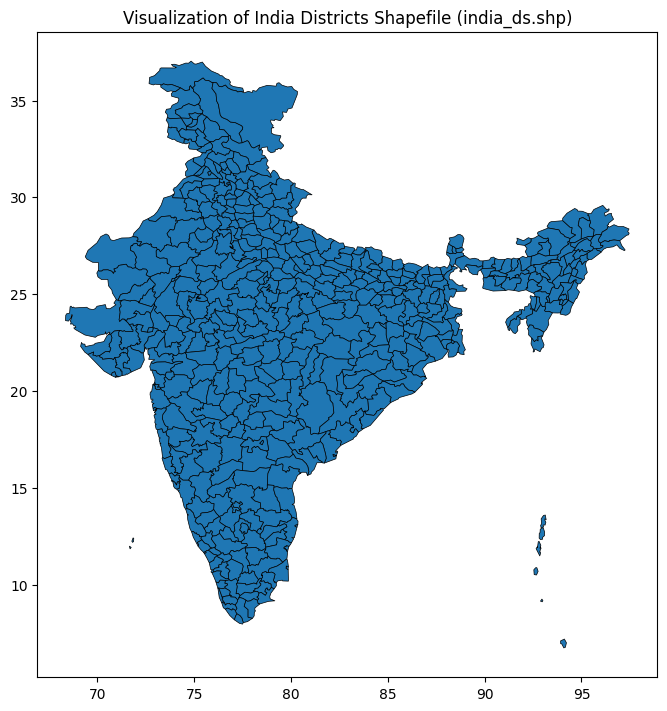

In [ ]:
import matplotlib.pyplot as plt

print("--- Visualizing the loaded data ---")

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
districts_gdf.plot(ax=ax, edgecolor='black', linewidth=0.5)
ax.set_title("Visualization of India Districts Shapefile (india_ds.shp)")
plt.show()

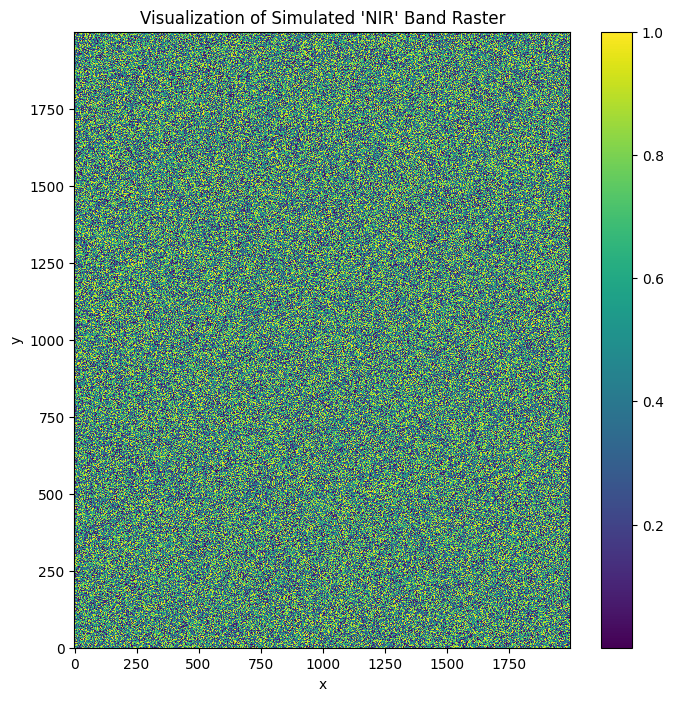

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
landsat_sim.sel(band='NIR').plot(ax=ax, cmap='viridis')
ax.set_title("Visualization of Simulated 'NIR' Band Raster")
plt.show()

In [ ]:
import numba

print("--- Defining functions for NDVI calculation ---")

# Standard function using vectorized NumPy
def calculate_ndvi_numpy(raster_da):
    nir_band = raster_da.sel(band='NIR').values
    red_band = raster_da.sel(band='Red').values
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-8)
    return ndvi

# Numba-accelerated function using loops
@numba.jit(nopython=True)
def calculate_ndvi_numba(nir_band, red_band):
    output_ndvi = np.empty(nir_band.shape, dtype=np.float32)
    for y in range(nir_band.shape[0]):
        for x in range(nir_band.shape[1]):
            denominator = nir_band[y, x] + red_band[y, x] + 1e-8
            output_ndvi[y, x] = (nir_band[y, x] - red_band[y, x]) / denominator
    return output_ndvi

print("NumPy and Numba NDVI functions are ready.")

--- Defining functions for NDVI calculation ---
NumPy and Numba NDVI functions are ready.


In [ ]:
import dask_geopandas

print("--- Preparing for parallel vector operations with Dask ---")

# Convert your districts GeoDataFrame into a Dask GeoDataFrame
# npartitions can be set to the number of CPU cores you have
ddf = dask_geopandas.from_geopandas(districts_gdf, npartitions=4)

print(f"Converted districts shapefile to Dask GeoDataFrame with {ddf.npartitions} partitions.")

--- Preparing for parallel vector operations with Dask ---
Converted districts shapefile to Dask GeoDataFrame with 4 partitions.


In [ ]:
import pandas as pd
import xarray as xr
import numpy as np

print("--- Simulating and analyzing a large climate dataset ---")

# Simulate 30 years of monthly temperature data
time_coords = pd.date_range(start='1990-01-01', end='2019-12-31', freq='MS')
lat_coords = np.arange(18, 22, 0.25)
lon_coords = np.arange(72, 76, 0.25)

# Create a Dask-chunked DataArray for parallel processing
climate_data_sim = xr.DataArray(
    np.random.rand(len(time_coords), len(lat_coords), len(lon_coords)),
    coords={'time': time_coords, 'latitude': lat_coords, 'longitude': lon_coords},
    dims=['time', 'latitude', 'longitude'],
    name='temperature'
).chunk({'time': 120})

# Define the task: calculate the mean temperature for each year
annual_mean_temp = climate_data_sim.groupby('time.year').mean()

print("Time-aggregation task (annual mean temperature) defined.")

--- Simulating and analyzing a large climate dataset ---
Time-aggregation task (annual mean temperature) defined.


In [ ]:
# This is a conceptual example and will not execute without a Ray installation.
print("--- Conceptual Example for Parallelization with Ray (not executed) ---")
# import ray

# @ray.remote
# def get_geometry_area(geometry):
#     return geometry.area

# ray.init()
# futures = [get_geometry_area.remote(geom) for geom in districts_gdf.geometry]
# results = ray.get(futures)
# ray.shutdown()
# print(f"Ray could calculate {len(results)} areas in parallel.")

--- Conceptual Example for Parallelization with Ray (not executed) ---


In [ ]:
import time

print("--- Step 8: Comparing Execution Times ---")
timing_results = {}

# Time NDVI calculation (Step 4)
print("Timing NDVI calculations...")
start = time.time()
ndvi_numpy = calculate_ndvi_numpy(landsat_sim)
timing_results['NDVI (NumPy)'] = time.time() - start

nir_band = landsat_sim.sel(band='NIR').values
red_band = landsat_sim.sel(band='Red').values
_ = calculate_ndvi_numba(nir_band, red_band) # First run for compilation
start = time.time()
ndvi_numba = calculate_ndvi_numba(nir_band, red_band)
timing_results['NDVI (Numba)'] = time.time() - start

# Time vector buffering (Step 5)
print("Timing vector buffer operations...")
start = time.time()
gdf_buffered = districts_gdf.buffer(0.01)
timing_results['Buffer (GeoPandas)'] = time.time() - start

start = time.time()
ddf_buffered = ddf.buffer(0.01).compute()
timing_results['Buffer (Dask)'] = time.time() - start

# Print formatted results
print("\n--- Performance Comparison Summary ---")
print("--------------------------------------------------")
print(f"{'Task':<25} | {'Execution Time (s)':<20}")
print("--------------------------------------------------")
for task, duration in timing_results.items():
    print(f"{task:<25} | {duration:<20.4f}")
print("--------------------------------------------------")

--- Step 8: Comparing Execution Times ---
Timing NDVI calculations...
Timing vector buffer operations...

--- Performance Comparison Summary ---
--------------------------------------------------
Task                      | Execution Time (s)  
--------------------------------------------------
NDVI (NumPy)              | 0.0197              
NDVI (Numba)              | 0.0260              
Buffer (GeoPandas)        | 0.3046              
Buffer (Dask)             | 0.7461              
--------------------------------------------------



--- Step 9: Visualizing final outputs ---
Displaying NDVI map...


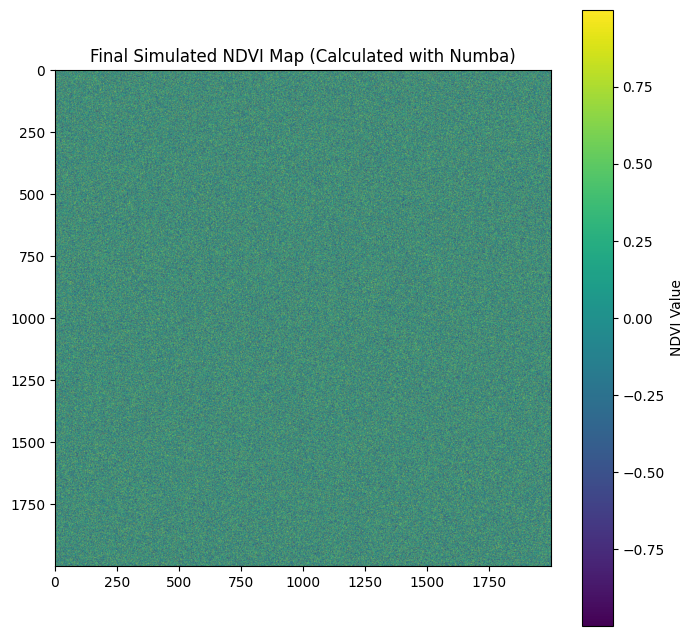

In [ ]:
import matplotlib.pyplot as plt

print("\n--- Step 9: Visualizing final outputs ---")

# Plot the calculated NDVI map
print("Displaying NDVI map...")
plt.figure(figsize=(8, 8))
plt.imshow(ndvi_numba, cmap='viridis')
plt.colorbar(label='NDVI Value')
plt.title('Final Simulated NDVI Map (Calculated with Numba)')
plt.show()

Displaying climate time series plot...


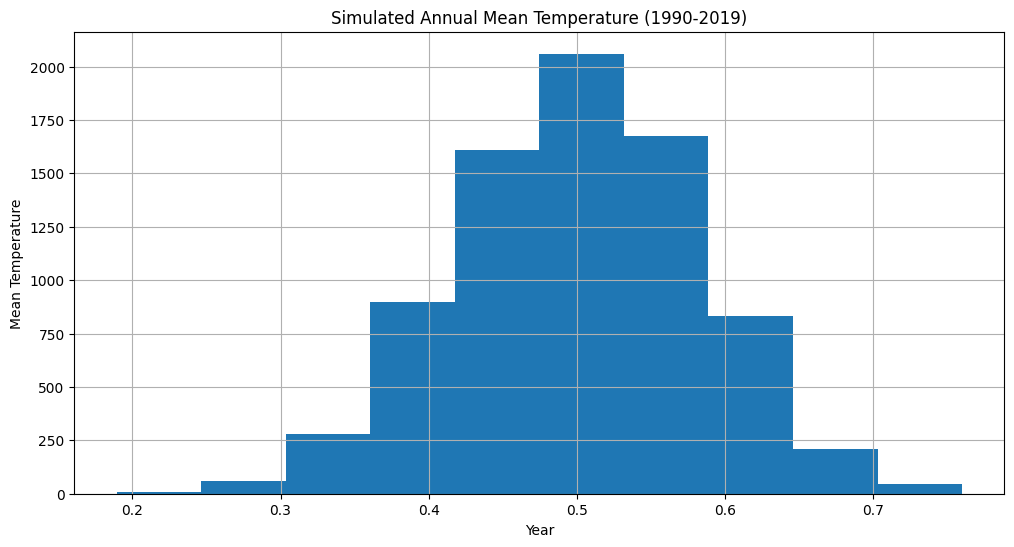

In [ ]:
print("Displaying climate time series plot...")
plt.figure(figsize=(12, 6))
annual_mean_temp.compute().plot()
plt.title('Simulated Annual Mean Temperature (1990-2019)')
plt.xlabel('Year')
plt.ylabel('Mean Temperature')
plt.grid(True)
plt.show()